# Libraries

In [1]:
# for local import
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [8]:
# for working with data
import pandas as pd
import numpy as np
import scipy.sparse

# for preprocessing
from src.preprocessing import BasicTextCleaning
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# for modelling
from sklearn.linear_model import LogisticRegression

# for evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score

# Load Data

In [3]:
osf = pd.read_csv("../../data/fake_reviews_dataset.csv")
print("Shape of OFS: ", osf.shape)
# osf.head()
osf

Shape of OFS:  (40432, 4)


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


<Axes: xlabel='label', ylabel='count'>

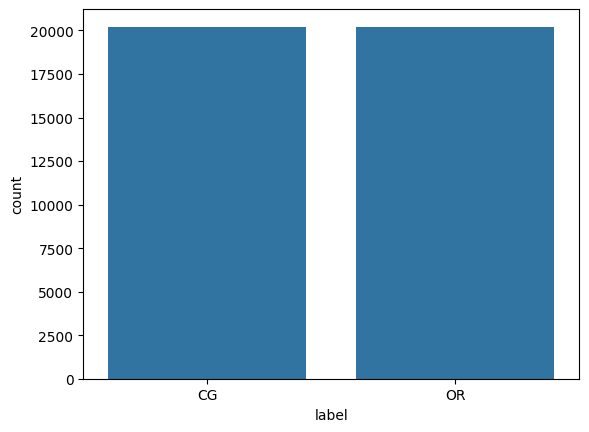

In [4]:
import seaborn as sns
count = osf['label'].value_counts()
count
sns.barplot(x=count.index, y=count)

# Preprocessing

### Basic Text Cleaning

In [5]:
cleaner = BasicTextCleaning()

In [6]:
try:
    osf_cleaned = pd.read_csv("../../data/cleaned/osf_cleaned.csv")
    osf_cleaned = osf_cleaned.replace(np.nan, '')
except:
    osf_cleaned = pd.DataFrame()
    osf_cleaned['length'] = osf['text_'].apply(lambda x: len(x))
    osf_cleaned['texts'] = cleaner.text_cleaning(osf['text_'])

    ordinal = OrdinalEncoder(categories=[['OR', 'CG']], dtype=int)
    osf_cleaned['labels'] = ordinal.fit_transform(osf[['label']])
    osf_cleaned.to_csv("../../data/cleaned/osf_cleaned.csv", index=False)

In [41]:
from nltk import ngrams

class AvgWord2Vec:
    def __init__(self, vector_size=300, min_count=1, sg=1, ngram_range=(1, 1), window=5, seed=42):
        self.w2v = Word2Vec(vector_size=vector_size, min_count=min_count, sg=sg,
                            window=window, workers=5, seed=seed)
        self.min_count = min_count
        self.sg = sg
        self.window = window
        self.seed = seed
        self.vsize = vector_size

        self.ngrams = np.arange(ngram_range[0], ngram_range[1]+1, 1)
        self.raw = None
        self.corpus = None
        self.vocabulary_ = None

    def _create_ngrams(self, n, X):
        phrases = [list(ngrams(sent.split(), n)) for sent in X]
        for i in range(len(phrases)):
            phrases[i] = [" ".join(word) for word in phrases[i]]
        return phrases
    
    def _create_corpus(self, X, update_train=False):
        ngrams_phrases = {}
        for n in self.ngrams:
            phrases = self._create_ngrams(n, X)
            ngrams_phrases[f"{n}"] = phrases
        data = []
        corpus = []
        for n in ngrams_phrases.values():
            if len(data)==0:
                data = n
            data = [data[i] + n[i] for i in range(len(data))]
            corpus.extend(n)
        if update_train:
            self.corpus = corpus
        return data
    
    def _avg_sentence(self, data):
        avg_sentences = []
        for sent in data:
            if len(sent)!=0:
                avg_sentence = np.mean([self.w2v.wv.get_vector(word) for word in sent
                                        if word in self.w2v.wv.index_to_key], axis=0)
            else:
                avg_sentence = np.zeros(self.vsize)
            avg_sentences.append(avg_sentence)
        return np.array(avg_sentences)

    def fit(self, X):
        self.w2v = Word2Vec(vector_size=self.vsize, min_count=self.min_count, sg=self.sg,
                            window=self.window, workers=5, seed=self.seed)
        self.raw = list(X)
        self._create_corpus(update_train=True, X=X)
        self.w2v.build_vocab(self.corpus)
        self.w2v.train(self.corpus, total_examples=self.w2v.corpus_count, epochs=self.w2v.epochs)
        self.vocabulary_ = self.w2v.wv.key_to_index

    def fit_transform(self, X):
        self.w2v = Word2Vec(vector_size=self.vsize, min_count=self.min_count, sg=self.sg,
                            window=self.window, workers=5, seed=self.seed)
        self.raw = list(X)
        data = self._create_corpus(update_train=True, X=X)
        self.w2v.build_vocab(self.corpus)
        self.w2v.train(self.corpus, total_examples=self.w2v.corpus_count, epochs=self.w2v.epochs)
        self.vocabulary_ = self.w2v.wv.key_to_index
        return scipy.sparse.csr_matrix(self._avg_sentence(data))
        
    def transform(self, X):
        data = self._create_corpus(update_train=False, X=X)
        return scipy.sparse.csr_matrix(self._avg_sentence(data))
    
    def get_feature_names_out(self):
        columns = np.array([f'component_{i+1}' for i in range(self.vsize)])

texts = ["I love eating chocolate icecream and strawberry cake",
         "Dogs are obedient"]
y = ["julia nice",
     "bibimbap"]
x = ["i love you",
     "beautiful girl"]

w2v = AvgWord2Vec(ngram_range=(1, 1))
w2v.fit_transform(x).toarray().shape

(2, 300)

In [42]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(osf_cleaned['texts'])

<40432x28217 sparse matrix of type '<class 'numpy.float64'>'
	with 993426 stored elements in Compressed Sparse Row format>

In [43]:
tfidf.get_feature_names_out()

array(['00', '000', '0005', ..., 'zurg', 'zyliss', 'zymox'], dtype=object)

In [44]:
def avg_word2vec(sentences, w2v_model):
    avg_sentences = []
    for sentence in sentences:
        if sentence:
            avg_sentence = np.mean([w2v_model.wv.get_vector(word) for word in sentence if word in w2v_model.wv.key_to_index], axis=0)
        else:
            avg_sentence = np.zeros(w2v_model.vector_size)
        avg_sentences.append(avg_sentence)
    return np.array(avg_sentences)

def text_extractor(X_train, X_test, extractor):
    if isinstance(extractor, Word2Vec):
        vector_size = extractor.vector_size
        window = extractor.window
        sg = extractor.sg
        extractor = Word2Vec(vector_size=vector_size, sg=sg, window=window, min_count=1, workers=5, seed=42)

        cleaner = BasicTextCleaning()
        X_train = cleaner.text_cleaning(texts=X_train, methods=['tokenization'])
        X_test = cleaner.text_cleaning(texts=X_test, methods=['tokenization'])

        extractor.build_vocab(X_train)
        extractor.train(X_train, total_examples=extractor.corpus_count, epochs=30)
        X_train = avg_word2vec(X_train, extractor)
        X_train = pd.DataFrame(X_train, columns=[str(i) for i in range(extractor.vector_size)])
        X_test = avg_word2vec(X_test, extractor)
        X_test = pd.DataFrame(X_test, columns=[str(i) for i in range(extractor.vector_size)])
    else:
        X_train = extractor.fit_transform(X_train).toarray()
        X_test = extractor.transform(X_test).toarray()
        X_train = pd.DataFrame(X_train, columns=extractor.get_feature_names_out())
        X_test = pd.DataFrame(X_test, columns=extractor.get_feature_names_out())
    
    variance = VarianceThreshold()
    X_train = variance.fit_transform(X_train)
    X_test = variance.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=variance.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=variance.get_feature_names_out())

    return X_train, X_test

def text_extractor(X_train, X_test, extractor):
    # if isinstance(extractor, Word2Vec):
    #     vector_size = extractor.vector_size
    #     window = extractor.window
    #     sg = extractor.sg
    #     extractor = Word2Vec(vector_size=vector_size, sg=sg, window=window, min_count=1, workers=5, seed=42)

    #     cleaner = BasicTextCleaning()
    #     X_train = cleaner.text_cleaning(texts=X_train, methods=['tokenization'])
    #     X_test = cleaner.text_cleaning(texts=X_test, methods=['tokenization'])

    #     extractor.build_vocab(X_train)
    #     extractor.train(X_train, total_examples=extractor.corpus_count, epochs=30)
    #     X_train = avg_word2vec(X_train, extractor)
    #     X_train = pd.DataFrame(X_train, columns=[str(i) for i in range(extractor.vector_size)])
    #     X_test = avg_word2vec(X_test, extractor)
    #     X_test = pd.DataFrame(X_test, columns=[str(i) for i in range(extractor.vector_size)])
    # else:
    X_train = extractor.fit_transform(X_train).toarray()
    X_test = extractor.transform(X_test).toarray()
    X_train = pd.DataFrame(X_train, columns=extractor.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=extractor.get_feature_names_out())
    
    variance = VarianceThreshold()
    X_train = variance.fit_transform(X_train)
    X_test = variance.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=variance.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=variance.get_feature_names_out())

    return X_train, X_test

def feature_selection(X_train, X_test, selector):
    X_train = selector.fit_transform(X_train)
    X_test = selector.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=selector.get_feature_names_out())
    X_test = pd.DataFrame(X_test, columns=selector.get_feature_names_out())
    
    return X_train, X_test

In [45]:
def modelling(model, X_train, y_train, X_test, probability=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if probability:
        y_pred_proba = model.predict_proba(X_test)
        return y_pred, y_pred_proba
    return y_pred

def evaluation(y_true, y_pred, y_pred_prob, scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc']):
    scores = {'accuracy': accuracy_score,
              'f1': f1_score,
              'recall': recall_score,
              'precision': precision_score,
              'roc_auc': roc_auc_score}
    
    result = {}
    for method in scoring:
        if method == 'roc_auc':
            result[method] = scores[method](y_true, y_pred_prob.T[1])
        else:
            result[method] = scores[method](y_true, y_pred)

    return result

In [46]:
def cross_validation(data, extractor, model=None, selector=None, length_scaler=None,
                     scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], cv=5,
                     avg_output=True, quiet=True):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = {method: [] for method in scoring}
    round = 1

    for train_indices, test_indices in kfolds.split(data.iloc[:, :-1], data.iloc[:, -1]):
        train_set, test_set = data.iloc[train_indices, :-1], data.iloc[test_indices, :-1]
        y_train, y_test = data.iloc[train_indices, -1], data.iloc[test_indices, -1]

        X_train, X_test = text_extractor(X_train=train_set['texts'], X_test=test_set['texts'], extractor=extractor)

        if length_scaler is not None:
            X_train['length'] = length_scaler.fit_transform(train_set[['length']])
            X_test['length'] = length_scaler.transform(test_set[['length']])
        
        if selector is not None:
            X_train, X_test = feature_selection(X_train, X_test, selector)

        y_pred, y_pred_prob = modelling(model, X_train, y_train, X_test)

        result = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_prob, scoring=scoring)
        for method in scoring:
            scores[method].append(result[method])
            
        if not quiet:
            print(f"round {round}: done")

        round += 1
        
    if avg_output:
        avg_scores = {key: np.mean(values) for key, values in scores.items()}

    return avg_scores

In [47]:
extractor = AvgWord2Vec(window=2, vector_size=50, seed=42, sg=0)
model = LogisticRegression(max_iter=1000, class_weight="balanced")
# model = SVC(probability=True, class_weight='balanced')
# extractor = TfidfVectorizer(min_df=0.001, ngram_range=(1, 1))
# model = SVC()

cross_validation(data=osf_cleaned, length_scaler=StandardScaler(),
                 model=model, extractor=extractor, quiet=False)

round 1: done
round 2: done
round 3: done
round 4: done
round 5: done


{'accuracy': 0.8157894326358898,
 'f1': 0.8178101616385056,
 'recall': 0.8270010232539085,
 'precision': 0.8088330039753417,
 'roc_auc': 0.87974034344771}

In [10]:
testcases = {'data': {'osf': osf_cleaned},
             'length_used': {'None': None,
                             'StandardScaler': StandardScaler(),
                             'MinMaxScaler': MinMaxScaler()},
             'feature_extraction': ['Word2Vec(vector_size={}, window={})'],
             'feature selection': {'None': None,
                                   'PCA': PCA,
                                   'SelectKBest(score_func={}, k={})': SelectKBest},
             'model': {'LogisticRegression(max_iter=1000, class_weight="balanced")': LogisticRegression(max_iter=1000, class_weight='balanced')}}

In [11]:
output = {'data': [],
          'length_used': [],
          'feature_extraction': [],
          'feature_selection': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': [],
          'notes': []}

In [12]:
# output = {'data': [],
#           'length_used': [],
#           'feature_extraction': [],
#           'feature_selection': [],
#           'model': [],
#           'accuracy': [],
#           'f1': [],
#           'recall': [],
#           'precision': [],
#           'roc_auc': [],
#           'notes': []}

# testcases = {'data': {'osf': osf_cleaned},
#              'length_used': {'None': None,
#                              'StandardScaler': StandardScaler(),
#                              'MinMaxScaler': MinMaxScaler()},
#              'feature_extraction': ['Word2Vec(vector_size={}, window={})'],
#              'feature selection': {'None': None},
#              'model': {'LogisticRegression(max_iter=1000, class_weight="balanced")': LogisticRegression(max_iter=1000, class_weight='balanced')}}

# for data_name in testcases['data']:
#     for length in testcases['length_used']:
#         if length == 'None':
#             data = testcases['data'][data_name].iloc[:, 1:].copy()
#         else:
#             data = testcases['data'][data_name].copy()
#         for size in np.arange(100, 1100, 100):
#             for window in range(3, 9, 2):
#                 extractor = Word2Vec(vector_size=size, window=window, workers=5, min_count=1, seed=42)
#                 for selector_name in testcases['feature selection']:
#                     selector = testcases['feature selection'][selector_name]
#                     for model_name in testcases['model']:
#                         model = testcases['model'][model_name]
#                         scores = cross_validation(data=data,
#                                                   length_scaler=testcases['length_used'][length],
#                                                   extractor=extractor,
#                                                   selector=selector,
#                                                   model=model)
                        
#                         output['data'].append(data_name)
#                         output['length_used'].append(length)
#                         output['feature_extraction'].append(f'Word2Vec(vector_size={size}, window={window})')
#                         output['feature_selection'].append(selector_name)
#                         output['model'].append(model_name)
#                         for key, values in scores.items():
#                             output[key].append(values)

output = {'data': [],
          'length_used': [],
          'feature_extraction': [],
          'feature_selection': [],
          'model': [],
          'accuracy': [],
          'f1': [],
          'recall': [],
          'precision': [],
          'roc_auc': [],
          'notes': []}

testcases = {'data': {'osf': osf_cleaned},
             'length_used': {'None': None},
             'feature_extraction': ['Word2Vec(vector_size={}, window={})'],
             'feature selection': {'None': None},
             'model': {'LogisticRegression(max_iter=1000, class_weight="balanced")': LogisticRegression(max_iter=1000, class_weight='balanced')}}

for data_name in testcases['data']:
    for length in testcases['length_used']:
        if length == 'None':
            data = testcases['data'][data_name].iloc[:, 1:].copy()
        else:
            data = testcases['data'][data_name].copy()
        for size in np.arange(700, 710, 100):
            for window in range(5, 9, 2):
                extractor = Word2Vec(vector_size=size, window=window, workers=5, min_count=1, seed=42, sg=1)
                for selector_name in testcases['feature selection']:
                    selector = testcases['feature selection'][selector_name]
                    for model_name in testcases['model']:
                        model = testcases['model'][model_name]
                        scores = cross_validation(data=data,
                                                  length_scaler=testcases['length_used'][length],
                                                  extractor=extractor,
                                                  selector=selector,
                                                  model=model)
                        
                        output['data'].append(data_name)
                        output['length_used'].append(length)
                        output['feature_extraction'].append(f'Word2Vec(vector_size={size}, window={window}, sg=1)')
                        output['feature_selection'].append(selector_name)
                        output['model'].append(model_name)
                        for key, values in scores.items():
                            output[key].append(values)

In [13]:
output_saved = output.copy()
output_saved['notes'] = ['']*len(output_saved['data'])
# # pd.DataFrame(output_saved).to_csv("data/result/test_result.csv", index=False)

In [14]:
output_saved_df = pd.DataFrame(output_saved)
output_saved_df

,data,length_used,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,None,"Word2Vec(vector_size=700, window=5, sg=1)",None,"LogisticRegression(max_iter=1000, class_weight...",0.864736,0.865342,0.869477,0.861249,0.926651,
1,osf,None,"Word2Vec(vector_size=700, window=7, sg=1)",None,"LogisticRegression(max_iter=1000, class_weight...",0.863821,0.864472,0.868847,0.860146,0.926498,


In [15]:
result = pd.read_csv('../../output/csv/word2vec.csv')
result = pd.concat([result, output_saved_df], axis=0, ignore_index=True)
# result.sort_values(by='accuracy', ascending=True)
# result[result['feature_extraction']=='Word2Vec(vector_size=100, window=5)']
result

,data,length_used,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,NaN,"Word2Vec(vector_size=100, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.842649,0.843850,0.850587,0.837234,0.906563,NaN
1,osf,NaN,"Word2Vec(vector_size=100, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.847769,0.848826,0.855068,0.842681,0.911585,NaN
2,osf,NaN,"Word2Vec(vector_size=100, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.849649,0.850687,0.856728,0.844732,0.913208,NaN
3,osf,NaN,"Word2Vec(vector_size=200, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.852518,0.853635,0.860505,0.846878,0.915526,NaN
4,osf,NaN,"Word2Vec(vector_size=200, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.854348,0.855324,0.861271,0.849461,0.917639,NaN
...,...,...,...,...,...,...,...,...,...,...,...
106,osf,NaN,"Word2Vec(vector_size=600, window=5, sg=1)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.863796,0.864541,0.869531,0.859616,0.925525,NaN
107,osf,NaN,"Word2Vec(vector_size=600, window=7, sg=1)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.863029,0.863597,0.867322,0.859918,0.924754,NaN
108,osf,NaN,"Word2Vec(vector_size=700, window=3, sg=1)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.863326,0.864018,0.868673,0.859418,0.925477,NaN
109,osf,None,"Word2Vec(vector_size=700, window=5, sg=1)",None,"LogisticRegression(max_iter=1000, class_weight...",0.864736,0.865342,0.869477,0.861249,0.926651,


In [16]:
# result.to_csv("../../output/csv/word2vec.csv", index=False)

In [51]:
pd.read_csv(r"../../output/csv/word2vec.csv").head(20)

,data,length_used,feature_extraction,feature_selection,model,accuracy,f1,recall,precision,roc_auc,notes
0,osf,NaN,"Word2Vec(vector_size=100, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.842649,0.843850,0.850587,0.837234,0.906563,NaN
1,osf,NaN,"Word2Vec(vector_size=100, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.847769,0.848826,0.855068,0.842681,0.911585,NaN
2,osf,NaN,"Word2Vec(vector_size=100, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.849649,0.850687,0.856728,0.844732,0.913208,NaN
3,osf,NaN,"Word2Vec(vector_size=200, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.852518,0.853635,0.860505,0.846878,0.915526,NaN
4,osf,NaN,"Word2Vec(vector_size=200, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.854348,0.855324,0.861271,0.849461,0.917639,NaN
5,osf,NaN,"Word2Vec(vector_size=200, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.856302,0.857377,0.864039,0.850829,0.918628,NaN
6,osf,NaN,"Word2Vec(vector_size=300, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.856623,0.857629,0.863930,0.851424,0.919816,NaN
7,osf,NaN,"Word2Vec(vector_size=300, window=5)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.859517,0.860394,0.866098,0.854766,0.921931,NaN
8,osf,NaN,"Word2Vec(vector_size=300, window=7)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.859493,0.860598,0.867477,0.853828,0.922632,NaN
9,osf,NaN,"Word2Vec(vector_size=400, window=3)",NaN,"LogisticRegression(max_iter=1000, class_weight...",0.858973,0.859875,0.865743,0.854087,0.921766,NaN
